In [1]:
!pip install -q \
    "transformers==4.44.2" \
    "datasets==2.20.0" \
    "huggingface_hub==0.24.7" \
    "speechbrain==1.0.2" \
    "accelerate==0.33.0" \
    "soundfile==0.12.1" \
    "sentencepiece==0.2.0" \
    "tokenizers==0.19.1" \
    "safetensors==0.4.4" \
    "numpy==1.26.4" \
    "torchaudio==2.4.0" \
    "matplotlib==3.9.2"



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os
os.environ["FORCE_SOUNDFILE"] = "1"

import importlib
import datasets.config as ds_config
ds_config.TORCHCODEC_AVAILABLE = False

import torch
import numpy as np
from datasets import load_dataset, concatenate_datasets, Audio
from huggingface_hub import login
from transformers import (
    SpeechT5Processor,
    SpeechT5ForTextToSpeech,
    SpeechT5HifiGan,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)
from dataclasses import dataclass
from typing import Any, Dict, List

In [ ]:
login("API_KEY")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
dsVoiceFemale = load_dataset("ZoniaChatbot/google-colombian-spanish-female-16000-1523")
dsVoicesFemale = load_dataset("ylacombe/google-colombian-spanish", "female")

In [5]:
print("Features:", dsVoiceFemale['train'].features)
print("Num rows:", dsVoiceFemale['train'].num_rows)
print()
print("Ejemplo:")

ejemplo_1 = dsVoiceFemale['train'][0]
for k, v in ejemplo_1.items():
    if k != 'audio':
        print(f"{k}: {v}")
    else:
        print(f"{k}: sampling_rate={v['sampling_rate']}, array_shape={len(v['array'])}")

Features: {'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='int64', id=None)}
Num rows: 150

Ejemplo:
audio: sampling_rate=16000, array_shape=81920
text: ¿Cuáles son las zonas dónde están los mejores restaurantes?
speaker_id: 1523


In [6]:
print("Features:", dsVoicesFemale['train'].features)
print("Num rows:", dsVoicesFemale['train'].num_rows)
print()
print("Ejemplo:")

ejemplo_2 = dsVoicesFemale['train'][0]
for k, v in ejemplo_2.items():
    if k != 'audio':
        print(f"{k}: {v}")
    else:
        print(f"{k}: sampling_rate={v['sampling_rate']}, array_shape={len(v['array'])}")

Features: {'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='int64', id=None)}
Num rows: 2369

Ejemplo:
audio: sampling_rate=48000, array_shape=229376
text: Quiero saber qué está pasando en Veracruz.
speaker_id: 2436


In [7]:
SEED = 42
N_SAMPLES = 150

sample_A = dsVoiceFemale['train']
sample_B = dsVoicesFemale['train']

print(f"dsVoiceFemale  : {len(sample_A)}")
print(f"dsVoicesFemale : {len(sample_B)}")

dsVoiceFemale  : 150
dsVoicesFemale : 2369


In [8]:
print("Features sample_A:", sample_A.features)
print("Features sample_B:", sample_B.features)

cols_A = set(sample_A.column_names)
cols_B = set(sample_B.column_names)
common_cols = list(cols_A & cols_B)
print("\nColumnas comunes:", common_cols)

sample_A = sample_A.select_columns(common_cols)
sample_B = sample_B.select_columns(common_cols)

Features sample_A: {'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='int64', id=None)}
Features sample_B: {'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='int64', id=None)}

Columnas comunes: ['audio', 'speaker_id', 'text']


In [9]:
ds_combined = concatenate_datasets([sample_A, sample_B])
ds_combined = ds_combined.shuffle(seed=SEED)

print(f"\nTotal de muestras: {len(ds_combined)}")
print(f"Features: {ds_combined.features}")


Total de muestras: 2519
Features: {'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'speaker_id': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None)}


In [10]:
for i in range(5):
    print(f"  {i}. {ds_combined[i]['text']}")

  0. ¿Quiero saber el origen de la palabra ladrón?
  1. Voy a mirar acá en mi base de datos
  2. ¿Qué necesito para aplicar para una tarjeta de crédito?
  3. Si quieres podemos ir juntos al cine yo no tengo problema
  4. Te estoy enviando lugares que puedes ir a visitar en tus momentos de descanso


In [11]:
TARGET_SR = 16000
ds_combined = ds_combined.cast_column("audio", Audio(sampling_rate=TARGET_SR))
print(f"Audio normalizado a {TARGET_SR} Hz")

Audio normalizado a 16000 Hz


In [12]:
MODEL_ID = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(MODEL_ID)
model = SpeechT5ForTextToSpeech.from_pretrained(MODEL_ID)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
import torch.nn as nn

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

spk_projector = nn.Linear(768, 512).to(DEVICE)

In [14]:
from speechbrain.inference.classifiers import EncoderClassifier

spk_model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-xvect-voxceleb",
    run_opts={"device": DEVICE}
)

def get_speaker_embedding(audio_array: np.ndarray) -> np.ndarray:
    waveform = torch.tensor(audio_array).unsqueeze(0).float().to(DEVICE)
    with torch.no_grad():
        embeddings = spk_model.encode_batch(waveform)
    return embeddings.squeeze().cpu().numpy()

test = get_speaker_embedding(np.zeros(16000, dtype=np.float32))
print(test.shape)
print(f"norm: {np.linalg.norm(test):.3f}")

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching fr

(512,)
norm: 99.876


In [15]:
def prepare_dataset(example):
    audio = example["audio"]
    array = np.array(audio["array"], dtype=np.float32)
    sr    = audio["sampling_rate"]

    inputs = processor(
        text=example["text"],
        audio_target=array,
        sampling_rate=sr,
        return_attention_mask=False,
    )

    labels = np.array(inputs["labels"], dtype=np.float32)
    while labels.ndim > 2:
        labels = labels.squeeze(0)
    
    if labels.shape[0] > 1500:
        labels = labels[:1500]

    if labels.shape[0] % 2 != 0:
        labels = labels[:-1]

    inputs["labels"] = labels
    inputs["speaker_embeddings"] = get_speaker_embedding(array)
    return inputs

ds_processed = ds_combined.map(
    prepare_dataset,
    remove_columns=ds_combined.column_names,
)

for i in range(3):
    lab = np.array(ds_processed[i]["labels"])
    spk = np.array(ds_processed[i]["speaker_embeddings"])
    print(f"{i}. labels: {lab.shape} | speaker_emb: {spk.shape}")

Map:   0%|          | 0/2519 [00:00<?, ? examples/s]

0. labels: (326, 80) | speaker_emb: (512,)
1. labels: (426, 80) | speaker_emb: (512,)
2. labels: (278, 80) | speaker_emb: (512,)


In [16]:
ds_split = ds_processed.train_test_split(test_size=0.1, seed=SEED)
train_ds = ds_split["train"]
eval_ds  = ds_split["test"]

print(f"Train: {len(train_ds)} muestras | Eval: {len(eval_ds)} muestras")

Train: 2267 muestras | Eval: 252 muestras


In [17]:
@dataclass
class TTSDataCollator:
    processor: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": torch.tensor(np.array(f["input_ids"]).flatten())} for f in features]
        batch = self.processor.tokenizer.pad(input_ids, padding=True, return_tensors="pt")

        label_features = [torch.tensor(np.array(f["labels"], dtype=np.float32)) for f in features]
        max_len = max(l.shape[0] for l in label_features)
        n_mels  = label_features[0].shape[1]

        padded_labels = torch.full((len(label_features), max_len, n_mels), fill_value=-100.0)
        for i, lab in enumerate(label_features):
            padded_labels[i, :lab.shape[0], :] = lab

        batch["labels"] = padded_labels
        batch["speaker_embeddings"] = torch.stack([
            torch.tensor(np.array(f["speaker_embeddings"], dtype=np.float32))
            for f in features
        ])

        return batch
    
data_collator = TTSDataCollator(processor=processor)

In [18]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts_colombian",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
    warmup_steps=200,
    num_train_epochs=80,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    logging_steps=10,
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
    fp16=False,
    bf16=True,
    dataloader_num_workers=4,
    report_to="none",
)

In [19]:
for i in range(5):
    lab = torch.tensor(np.array(ds_processed[i]["labels"], dtype=np.float32))
    print(f"[{i}] labels shape: {lab.shape}")

[0] labels shape: torch.Size([326, 80])
[1] labels shape: torch.Size([426, 80])
[2] labels shape: torch.Size([278, 80])
[3] labels shape: torch.Size([320, 80])
[4] labels shape: torch.Size([518, 80])


In [20]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=data_collator,
    tokenizer=processor,
)

trainer.train()

Epoch,Training Loss,Validation Loss
0,0.533800,0.464995
1,0.481500,0.437559
2,0.456000,0.422779
3,0.451000,0.412231
4,0.438300,0.406324
5,0.443200,0.393571
6,0.419100,0.389883
8,0.419900,0.383383
9,0.407500,0.379203
10,0.414500,0.384419


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generatio

TrainOutput(global_step=5600, training_loss=0.3815400084853172, metrics={'train_runtime': 4437.8429, 'train_samples_per_second': 40.867, 'train_steps_per_second': 1.262, 'total_flos': 1.2116560319996616e+16, 'train_loss': 0.3815400084853172, 'epoch': 79.01234567901234})

In [23]:
model.save_pretrained("./speecht5_tts_colombian_final")
processor.save_pretrained("./speecht5_tts_colombian_final")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}


[]

/tmp/ipykernel_15094/2602351248.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


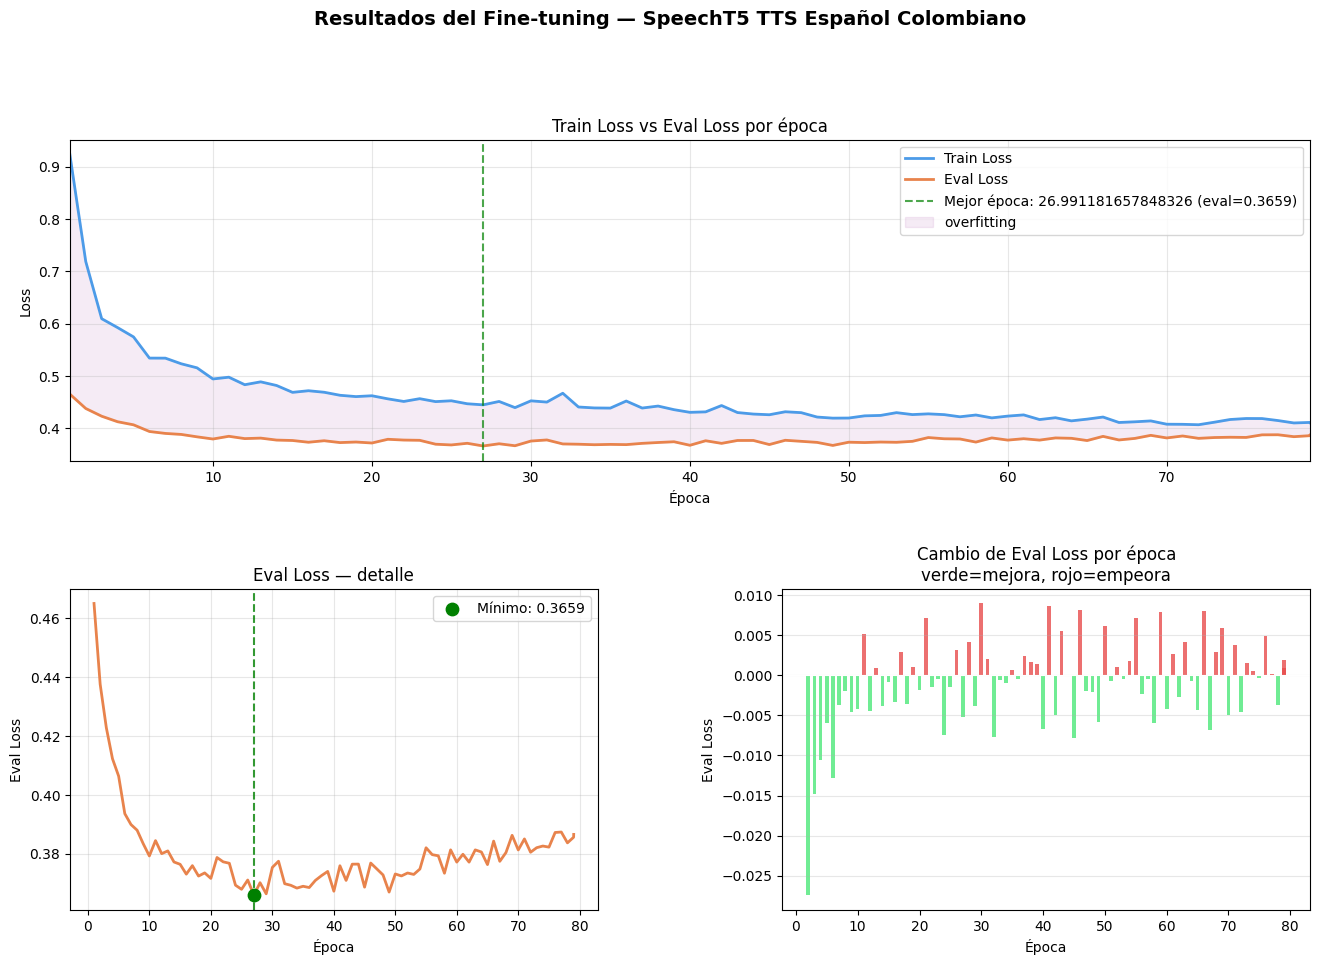

Épocas totales: 79
Mejor época: 26
Mejor eval loss: 0.3659
Train loss final: 0.4104
Eval loss inicial: 0.4650
Mejora total: 0.0991 (21.3%)
Overfitting (gap): 0.0239
Épocas sobreentrenadas: 53


In [29]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import json
import os

state_path = "./speecht5_tts_colombian/checkpoint-5600/trainer_state.json"
with open(state_path) as f:
    state = json.load(f)

epochs, train_loss, eval_loss = [], [], []
for log in state["log_history"]:
    if "eval_loss" in log:
        epochs.append(log["epoch"])
        eval_loss.append(log["eval_loss"])
    if "loss" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])

min_len = min(len(epochs), len(train_loss))
epochs     = epochs[:min_len]
train_loss = train_loss[:min_len]
eval_loss  = eval_loss[:min_len]

best_epoch = epochs[np.argmin(eval_loss)]
best_loss  = min(eval_loss)

fig = plt.figure(figsize=(16, 10))
fig.suptitle("Resultados del Fine-tuning — SpeechT5 TTS Español Colombiano", fontsize=14, fontweight="bold", y=1.01)
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.35)

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(epochs, train_loss, label="Train Loss", color="#4C9BE8", linewidth=2)
ax1.plot(epochs, eval_loss,  label="Eval Loss",  color="#E8834C", linewidth=2)
ax1.axvline(best_epoch, color="green", linestyle="--", alpha=0.7, label=f"Mejor época: {best_epoch} (eval={best_loss:.4f})")
ax1.fill_between(epochs, train_loss, eval_loss, alpha=0.08, color="purple", label="overfitting")
ax1.set_title("Train Loss vs Eval Loss por época")
ax1.set_xlabel("Época")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, max(epochs))

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(epochs, eval_loss, color="#E8834C", linewidth=2)
ax2.axvline(best_epoch, color="green", linestyle="--", alpha=0.8)
ax2.scatter([best_epoch], [best_loss], color="green", zorder=5, s=80, label=f"Mínimo: {best_loss:.4f}")
ax2.set_title("Eval Loss — detalle")
ax2.set_xlabel("Época")
ax2.set_ylabel("Eval Loss")
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[1, 1])
delta = np.diff(eval_loss)
ax3.bar(epochs[1:], delta, color=["#E84C4C" if d > 0 else "#4CE87A" for d in delta], alpha=0.8, width=0.6)
ax3.axhline(0, color="white", linewidth=0.8)
ax3.set_title("Cambio de Eval Loss por época\nverde=mejora, rojo=empeora")
ax3.set_xlabel("Época")
ax3.set_ylabel("Eval Loss")
ax3.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("training_results.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Épocas totales: {int(max(epochs))}")
print(f"Mejor época: {int(best_epoch)}")
print(f"Mejor eval loss: {best_loss:.4f}")
print(f"Train loss final: {train_loss[-1]:.4f}")
print(f"Eval loss inicial: {eval_loss[0]:.4f}")
print(f"Mejora total: {eval_loss[0] - best_loss:.4f} ({((eval_loss[0]-best_loss)/eval_loss[0])*100:.1f}%)")
print(f"Overfitting (gap): {train_loss[-1] - eval_loss[-1]:.4f}")

épocas_overfitting = next((i for i, e in enumerate(epochs) if e > best_epoch), None)
if épocas_overfitting:
    print(f"Épocas sobreentrenadas: {int(max(epochs)) - int(best_epoch)}")

In [26]:
embeddings = []
for i in range(20):
    audio = np.array(ds_combined[i]["audio"]["array"], dtype=np.float32)
    embeddings.append(get_speaker_embedding(audio))

spk_emb_avg = np.mean(embeddings, axis=0)
spk_emb_avg = spk_emb_avg / np.linalg.norm(spk_emb_avg)
spk_emb_avg = torch.tensor(spk_emb_avg).unsqueeze(0).to(DEVICE)

In [27]:
import re

def dividir_en_frases(texto: str, processor, max_tokens: int = 50) -> list:

    PATRONES_CORTE = [
        r',\s+',
        r'\s+(pero|sino|aunque|porque|cuando|donde|como|mientras|después|antes|entonces|así que|ya que)\s+',
        r'\s+(y|e|o|u)\s+(?=\w{4,})',
    ]
    
    n_tokens = processor(text=texto, return_tensors="pt")["input_ids"].shape[1]
    if n_tokens <= max_tokens:
        return [texto]
    
    for patron in PATRONES_CORTE:
        segmentos = re.split(f'({patron})', texto, flags=re.IGNORECASE)
        partes_candidatas = []
        chunk = ""
        
        for seg in segmentos:
            chunk += seg
            tok = processor(text=chunk.strip(), return_tensors="pt")["input_ids"].shape[1]
            if tok >= max_tokens:
                if partes_candidatas or chunk.strip():
                    anterior = chunk[:-(len(seg))].strip()
                    
                    if anterior:
                        partes_candidatas.append(anterior)
                    chunk = seg.strip()

        if chunk.strip():
            partes_candidatas.append(chunk.strip())
        
        if all(processor(text=p, return_tensors="pt")["input_ids"].shape[1] <= max_tokens for p in partes_candidatas) and len(partes_candidatas) > 1:
            return partes_candidatas
    
    palabras = texto.split()
    partes = []
    chunk_actual = []
    for palabra in palabras:
        chunk_actual.append(palabra)
        tok = processor(text=" ".join(chunk_actual), return_tensors="pt")["input_ids"].shape[1]
        if tok >= max_tokens:
            partes.append(" ".join(chunk_actual))
            chunk_actual = []
    if chunk_actual:
        partes.append(" ".join(chunk_actual))

    return partes


def recortar_silencio(audio: torch.Tensor, sr: int = 16000, margen_ms: int = 150) -> torch.Tensor:
    
    umbral = audio.abs().max().item() * 0.05
    umbral = max(umbral, 0.001)
    margen = int(sr * margen_ms / 1000)
    indices = (audio.abs() > umbral).nonzero(as_tuple=True)[0]
    
    if len(indices) == 0:
        return audio
    
    primero = max(0, indices[0].item() - margen)
    ultimo  = min(len(audio), indices[-1].item() + margen)
    
    return audio[primero:ultimo]


def generar_chunk(texto: str, threshold: float = 0.5, minlenratio: float = 0.1) -> torch.Tensor:
    inputs = processor_inf(text=texto.strip() + " .", return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        speech = model_inf.generate_speech(
            inputs["input_ids"],
            speaker_embeddings=spk_emb_avg,
            vocoder=vocoder,
            threshold=threshold,
            minlenratio=minlenratio,
            maxlenratio=20.0,
        )

    return speech.cpu()


def intentar_generar(parte: str, amp_minima: float = 0.05, profundidad: int = 0) -> list:
    
    MAX_PROFUNDIDAD = 3
    intentos = [
        {"threshold": 0.5, "minlenratio": 0.1},
        {"threshold": 0.4, "minlenratio": 0.2},
        {"threshold": 0.6, "minlenratio": 0.0},
    ]
    
    for params in intentos:
        speech = generar_chunk(parte, params["threshold"], params["minlenratio"])
        amp = speech.abs().max().item()
        n_tok = processor_inf(text=parte, return_tensors="pt")["input_ids"].shape[1]
        
        if amp >= amp_minima:
            return [recortar_silencio(speech)]

    palabras = parte.strip().split()
    if len(palabras) <= 2 or profundidad >= MAX_PROFUNDIDAD:
        return []

    mitad = len(palabras) // 2
    parte_a = " ".join(palabras[:mitad])
    parte_b = " ".join(palabras[mitad:])

    silencio_corto = torch.zeros(1600)
    resultado  = intentar_generar(parte_a, amp_minima, profundidad + 1)
    resultado += [silencio_corto]
    resultado += intentar_generar(parte_b, amp_minima, profundidad + 1)

    return resultado

In [28]:
import soundfile as sf
import re
from IPython.display import Audio as IPyAudio

model_inf = SpeechT5ForTextToSpeech.from_pretrained("./speecht5_tts_colombian_final").to(DEVICE)
processor_inf = SpeechT5Processor.from_pretrained("./speecht5_tts_colombian_final")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(DEVICE)
model_inf.eval()

def preparar_texto(texto: str) -> str:
    texto = texto.replace("¿", "").replace("¡", "")
    texto = texto.replace(",", "").replace(".", "")
    texto = texto.replace(":", "").replace(";", "")
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

def generar_audio(texto: str, nombre: str = "output.wav", max_tokens: int = 50):
    
    texto_limpio = preparar_texto(texto)
    partes = dividir_en_frases(texto_limpio, processor_inf, max_tokens)
    partes_filtradas = []
    
    for parte in partes:
        n_tok = processor_inf(text=parte, return_tensors="pt")["input_ids"].shape[1]
        if n_tok < 15 and partes_filtradas:
            partes_filtradas[-1] = partes_filtradas[-1] + " " + parte
        else:
            partes_filtradas.append(parte)

    partes = partes_filtradas
    for i, p in enumerate(partes):
        n_tok = processor_inf(text=p, return_tensors="pt")["input_ids"].shape[1]
        print(f"  {i+1}. '{p}' ({n_tok} tokens)")

    audios  = []
    for j, parte in enumerate(partes):
        print(f"\nGenerando parte {j+1}:")
        chunks = intentar_generar(parte)
        audios += chunks
        if j < len(partes) - 1:
            audios.append(torch.zeros(3200))

    if not audios:
        print("Error Audio")
        return

    audio_final = torch.cat(audios)
    if audio_final.abs().max().item() > 0.001:
        sf.write(nombre, audio_final.numpy(), samplerate=16000)
        display(IPyAudio(nombre))
    else:
        print("Error Audio")


generar_audio("Hola parce como esta hoy usted", "output_1.wav")
generar_audio("Hola parce que dia tan bueno hace hoy me voy a tomar un tinto y después salgo a dar una vuelta por el parque", "output_2.wav")
generar_audio("Buenos dias Mano, llevela suave para que no des papaya", "output_3.wav")

  1. 'Hola parce como esta hoy usted' (32 tokens)

Generando parte 1:


  1. 'Hola parce que dia tan bueno hace hoy me voy a tomar' (54 tokens)
  2. 'un tinto y después salgo a dar una vuelta por el parque' (57 tokens)

Generando parte 1:

Generando parte 2:


  1. 'Buenos dias Mano llevela suave para que no des papaya' (55 tokens)

Generando parte 1:
